In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 80% !important; }</style>"))

In [2]:
##### 대신증권 연결 확인
import win32com.client

instCpCybos = win32com.client.Dispatch("CpUtil.CpCybos")
print(instCpCybos.IsConnect)

from Tools import get_code, get_name

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from sklearn.preprocessing import minmax_scale
from statsmodels.tsa.stattools import coint
today = datetime.today().strftime("%Y%m%d") 

1


In [4]:
class Backtest():
    
    def __init__(self,code1,code2):
        
        self.today = datetime.today().strftime("%Y%m%d")
        self.code_1 = code1
        self.code_2 = code2   
        self.name_1 = get_name(code1)
        self.name_2 = get_name(code2)

 # 분 차트 받아오기
    def get_data(self,code,day):  # 종목, 기간, 오늘, 시점, 분, 시간간격
        
        today = self.today
        start = (datetime.today() - timedelta(day)).strftime("%Y%m%d") 
        
        temp = {}

        instStockChart = win32com.client.Dispatch("CpSysDib.StockChart")
        instStockChart.SetInputValue(0, code )
        instStockChart.SetInputValue(1, ord('1'))
        instStockChart.SetInputValue(2, today)
        instStockChart.SetInputValue(3, start)
        # instStockChart.SetInputValue(4, 1000)
        instStockChart.SetInputValue(5, (0,1,5))
        instStockChart.SetInputValue(6, ord('m'))  # 'D':일 'm' : 분, 'T' : 틱
        instStockChart.SetInputValue(7, 1)      # 데이터 주기
        instStockChart.SetInputValue(9, ord('1'))
        instStockChart.SetInputValue(10, 3)

        instStockChart.BlockRequest()

        numData = instStockChart.GetHeaderValue(3)
        numField = instStockChart.GetHeaderValue(1) 

        for i in range(numData):
            temp[str(instStockChart.GetDataValue(0, i)) +'.'+ str(instStockChart.GetDataValue(1, i))] = [instStockChart.GetDataValue(2, i)]
        temp = pd.DataFrame(temp).transpose()
        temp.index.names = ['time']
        
        return temp[::-1]


    def check_pvalue(self,day):     

        stock_1 = self.get_data(self.code_1,day) * self.hedge_ratio_1
        stock_2 = self.get_data(self.code_2,day) * self.hedge_ratio_2
        
        temp =  pd.merge(left = stock_1 , right = stock_2, how = "inner", on = "time")
        temp.columns = [str(day)+str(1),str(day)+str(2) ]

        score, pvalue, _ = coint(temp[str(day)+str(1)], temp[str(day)+str(2)])
        temp = pd.DataFrame()
        
        return pvalue

    def hedge_ratio(self,hedge_ratio_1,hedge_ratio_2):
        
        self.hedge_ratio_1 = hedge_ratio_1
        self.hedge_ratio_2 = hedge_ratio_2
        
        
    def get_dataset(self,window_short,window_long,day,test_day):

        self.stock_1 = self.get_data(self.code_1,day) 
        self.stock_2 = self.get_data(self.code_2,day) 

        df =  pd.merge(left = self.stock_1 , right = self.stock_2, how = "inner", on = "time")
        df.columns = [self.name_1, self.name_2]        
        df['spread'] = df[self.name_1] * self.hedge_ratio_1- df[self.name_2]* self.hedge_ratio_2
        spread_short = df['spread'].rolling(window=window_short, center=False).mean()
        spread_long = df['spread'].rolling(window=window_long,center=False).mean()
        std_long = df['spread'].rolling(window=window_long,center=False).std()
        zscore = pd.DataFrame((spread_short - spread_long)/std_long) ; zscore.columns = ['zscore']
        zscore.dropna(inplace = True) 
        df =  pd.merge(left = df , right = zscore, how = "inner", on = "time")                
        
        split = np.where(np.array(df.index)> str(test_day))[0][0]
        self.df_train = df.iloc[:split]
        self.df_test  = df.iloc[split:]
        
        score, pvalue, _ = coint(np.log(self.df_train[self.name_1]),np.log(self.df_train[self.name_2]))
        print('time interval : ',day,' , ','Cointegration test p-value: ' + str(pvalue))
        print(self.df_train.corr(method='pearson'))        
        
        self.df = df
        self.S1_train = self.df_train[self.name_1]
        self.S2_train = self.df_train[self.name_2]
        self.S1_test = self.df_test[self.name_1]
        self.S2_test = self.df_test[self.name_2]
        self.zscore_train = self.df_train['zscore']
        self.zscore_test = self.df_test['zscore']
        self.time_train = self.df_train.index
        self.time_test = self.df_test.index
    
    def threshold(self,threshold):
        self.threshold = threshold

        
    #Trade using a simple strategy
    #Trade using a simple strategy
    def trade(self, train, money, window_short, window_long):
        
        if train == 'train':
            S1 = self.S1_train
            S2 = self.S2_train
            zscore = self.zscore_train
            time = self.time_train
        elif train == 'test':
            S1 = self.S1_test
            S2 = self.S2_test    
            zscore = self.zscore_test
            time = self.time_test

        hedge_ratio_1 = self.hedge_ratio_1
        hedge_ratio_2 = self.hedge_ratio_2

        fee_buy = (1.00015)
        fee_sell = (1-0.00015)

        cash = money
        
        threshold = self. threshold
        
        # If window length is 0, algorithm doesn't make sense, so exit
        if (window_short == 0) or (window_long == 0):
            return 0

        # Simulate trading

        # Start with no money and no positions        
        count_S1 = 0 
        count_S2 = 0     

        for i in range(len(zscore)):        
            print(i+1,'번째거래')
            if cash < min(S1[i],S2[i]) :
                continue  
            
            # buy short if the z-score is > 1
            if zscore[i] > threshold:   # buy S1  buy S2

                count_S1 += hedge_ratio_1
                count_S2 += hedge_ratio_2

                cash -=  S1[i] * hedge_ratio_1 * fee_buy + S2[i] * hedge_ratio_2 * fee_buy

                eval_S1 = count_S1 * S1[i] *fee_sell 
                eval_S2 = count_S2 * S2[i] *fee_sell
                eval_total = eval_S1+ eval_S2 

                print( '[',time[i],']-----------',self.name_1,'현재가 :',S1[i],' / ',self.name_2,'현재가 :',S2[i], '  /  zscore :',zscore[i])
                print('[buy_INFO]  ',self.name_1,'매수금액 :',S1[i]* hedge_ratio_1*fee_buy,'/ ',self.name_2,'매수금액 :',S2[i]*hedge_ratio_2* fee_buy,
                      str(self.name_1),':',count_S1,'주  /  ',str(self.name_2),':',count_S2,'주')
                print('[buy]' ,'잔고: ',round(eval_total + cash,2),'원  ', ' / 평가금액 :',eval_total,'/ 예수금 :',cash )
            
            if zscore[i] < threshold:   # buy S1  buy S2

                count_S1 += hedge_ratio_3
                count_S2 += hedge_ratio_4

                cash -=  S1[i] * hedge_ratio_3 * fee_buy + S2[i] * hedge_ratio_4 * fee_buy

                eval_S1 = count_S1 * S1[i] *fee_sell 
                eval_S2 = count_S2 * S2[i] *fee_sell
                eval_total = eval_S1+ eval_S2 

                print( '[',time[i],']-----------',self.name_1,'현재가 :',S1[i],' / ',self.name_2,'현재가 :',S2[i], '  /  zscore :',zscore[i])
                print('[buy_INFO]  ',self.name_1,'매수금액 :',S1[i]* hedge_ratio_3*fee_buy,'/ ',self.name_2,'매수금액 :',S2[i]*hedge_ratio_4* fee_buy,
                      str(self.name_1),':',count_S1,'주  /  ',str(self.name_2),':',count_S2,'주')
                print('[buy]' ,'잔고: ',round(eval_total + cash,2),'원  ', ' / 평가금액 :',eval_total,'/ 예수금 :',cash )

            # Clear positions if the z-score between -.5 and .5        
            # -0.5~0.5 사이인 경우 수익일 경우 이익 실현
            elif abs(zscore[i]) < threshold :           

                eval_S1 = count_S1 * S1[i] * fee_sell
                eval_S2 = count_S2 * S2[i] * fee_sell
                eval_total = eval_S1 + eval_S2
                  
                temp_cash = cash + eval_S1 + eval_S2 
                if temp_cash > money :
                    cash = temp_cash
                    count_S1 = 0 
                    count_S2 = 0 -
                    print('[',time[i],']-----------',self.name_1,'현재가 :',S1[i],' / ',self.name_2,'현재가 :',S2[i])
                    print('[EXIT_INFO]' , '총매도금액 :',eval_S1*fee_sell,'원',' / 총매도금액 :', eval_S2 *fee_sell ,'원')
                    print('[EXIT]' ,'잔고: ',round(cash,2),'원  ',str(self.name_1),':',count_S1,'주  /  ',str(self.name_2),':',count_S2,'주' ) 

                else:
                    pass  

        eval_S1 = count_S1 * S1[-1] 
        eval_S2 = count_S2 * S2[-1] 
        
        if count_S1>0:
            count_S1 = 0
            count_S2 = 0
            cash += eval_S1 * fee_sell + eval_S2 * fee_sell    
            print('[',time[i],']-----------',self.name_1,'현재가 :',S1[i],' / ',self.name_2,'현재가 :',S2[i])
            print('[EXIT_INFO]' , '총매도금액 :',eval_S1*fee_sell,'원',' / 총매도금액 :', eval_S2 *fee_sell ,'원')
            print('[EXIT]' ,'잔고: ',round(cash,2),'원  ',str(self.name_1),':',count_S1,'주  /  ',str(self.name_2),':',count_S2,'주' ) 
        else:
            pass
                            
        return cash    

In [5]:
kodex200 = pd.read_pickle('kodex200')
kodex_x2 = pd.read_pickle('kodex_x2')
kodex_inv = pd.read_pickle('kodex_inversex2')
kodex_active = pd.read_pickle('kodex_active')
# tiger_active = pd.read_pickle('tiger_active')
temp =  pd.merge(left = kodex200 , right = kodex_x2, how = "inner", on = "time")
temp =  pd.merge(left = temp , right = kodex_inv, how = "inner", on = "time")
temp =  pd.merge(left = temp , right = kodex_active, how = "inner", on = "time")
# temp =  pd.merge(left = temp , right = tiger_active, how = "inner", on = "time")
temp.columns = ['kodex200','kodex_x2','kodex_invx2','kodex_active']
temp

,kodex200,kodex_x2,kodex_invx2,kodex_active
time,,,,
20200929.901,31030,14695,4190,10040
20200929.902,31010,14685,4195,10020
20200929.903,31035,14700,4190,10015
20200929.904,31015,14690,4195,10005
20200929.905,31010,14685,4195,10000
20200929.906,30995,14670,4200,9995
20200929.907,31040,14710,4190,10010
20200929.909,31015,14685,4190,9995
20200929.910,31015,14690,4195,9995


## 시뮬레이션

In [ ]:
test.trade('train',1000000, 1, 59)

## 백테스트

In [ ]:
test.trade('test',1000000, 5, 20)

## 윈도우 사이즈 그리드 서치

In [ ]:
# train
# length_scores = {}
# for i in range(1,20):
#     for j in range(5,60):
#         length_scores[test.trade('train',1000000, i, j)] = (i,j)
# best_length = max(length_scores.keys())
# print ('Best window length:', length_scores[best_length])
# print (best_length, 'day window:', length_scores[best_length])

# Test
length_scores2 = {}
for i in range(1,20):
    for j in range(5,60):
        length_scores2[test.trade('test',1000000, i, j)] = (i,j)
best_length2 = max(length_scores2.keys())
print (best_length2, 'day window:', length_scores2[best_length2])

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(length_scores)
plt.plot(length_scores2)
plt.xlabel('Window length')
plt.ylabel('Score')
plt.legend(['Training', 'Test'])
plt.show()

# -------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# #Trade using a simple strategy
# def trade(self, money, window_short, window_long):
    
#     S1 = self.stock_1
#     S2 = self.stock_2
    
#     hedge_ratio_1 = self.hedge_ratio_1
#     hedge_ratio_2 = self.hedge_ratio_2
    
#     # If window length is 0, algorithm doesn't make sense, so exit
#     if (window1 == 0) or (window2 == 0):
#         return 0

#     # Compute rolling mean and rolling standard deviation
#     zscore = self.get_zscore(window_short, window_long)
#     # Simulate trading
    
#     # Start with no money and no positions        
#     count_S1 = 0 ; temp1 = count_S1  #13
#     count_S2 = 0 ; temp2 = count_S2  #42
    

#     for i in range(len(zscore)):        
#         print(i+1,'번째 거래')
    
#         # Sell short if the z-score is > 1
#         if zscore[i] > 1:   # sell kospi  buy kosdaq

#             count_S1 -= hedge_ratio_1
#             count_S2 += hedge_ratio_2
            
#             buy_amount_S1.append(-S1[i]*hedge_ratio_1)
#             buy_amount_S2.append(S2[i] * hedge_ratio_2 * (1.004936563)) ; bookprice_S2 = sum(buy_amount_S2) / count_S2
#             buy_amount_total = sum(buy_amount_S1) + sum(buy_amount_S2)
            
#             cash +=  S1[i] *hedge_ratio_1* (1-0.004936563) - S2[i] * hedge_ratio_2 * (1.004936563)
            
#             eval_S1 = count_S1 * S1[i] * (1-0.001636563) - 700
#             eval_S2 = count_S2 * S2[i] * (1-0.001636563) - 700
#             eval_total = eval_S1 + eval_S2

#             balance = eval_total + cash
#             print('----',S1[i],S2[i])
#             print('bookprice' , bookprice_S1, bookprice_S2)
#             print('[SELL_INFO]',' kospi매도금액 :',S1[i]* hedge_ratio_1*(1-0.004936563),'/ kosdaq매수금액 :',S2[i]*hedge_ratio_2* (1.004936563))
#             print('[SELL]' ,'잔고: ',round(balance,2),'원', 'kospi :',count_S1,'주  /  kosdaq:',count_S2,'주' )
          
#         # Buy long if the z-score is < 1
#         elif zscore[i] < -1: # buy kospi sell kosdaq
                        
#             count_S1 += hedge_ratio_1
#             count_S2 -= hedge_ratio_2
            
#             buy_amount_S1.append(S1[i]*hedge_ratio_1* (1.004936563)) ; bookprice_S1 = sum(buy_amount_S1) / count_S1
#             buy_amount_S2.append(-bookprice_S2) 
#             buy_amount_total = sum(buy_amount_S1) + sum(buy_amount_S2)

#             cash +=  - S1[i] * hedge_ratio_1 * (1.004936563) + S2[i] * hedge_ratio_2 * (1-0.004936563)
            
#             eval_S1 = count_S1 * S1[i] * (1-0.001636563) - 700
#             eval_S2 = count_S2 * S2[i] * (1-0.001636563) - 700
#             eval_total = eval_S1 + eval_S2

#             balance = eval_total + cash
#             print('----',S1[i],S2[i])
#             print('bookprice' , bookprice_S1, bookprice_S2)
#             print('[BUY_INFO]',' kospi매수금액 :',S1[i]*hedge_ratio_1* (1.004936563),'/ kosdaq매도금액 :',S2[i]*hedge_ratio_2* (1-0.004936563))
#             print('[BUY]' ,'잔고: ',round(balance,2),'원','kospi :',count_S1,'주  /  kosdaq:',count_S2,'주' )

            
#         # Clear positions if the z-score between -.5 and .5        
#         # -0.5~0.5 사이인 경우 수익일 경우 이익 실현
#         elif abs(zscore[i]) < 0.5 :           
            
#             eval_S1 = count_S1 * S1[i] * (1-0.001636563) - 700
#             eval_S2 = count_S2 * S2[i] * (1-0.001636563) - 700
#             eval_total = eval_S1 + eval_S2
            
#             if (abs(S1[i]*(count_S1-temp1)) + abs(S2[i] * (count_S2-temp2))) >=400000 :                
#                 temp_cash = cash + (count_S1-temp1) * S1[i]*(1-0.001636563) - 700 - ( (temp2-count_S2) * S2[i]*(1.001636563)+700 )

#                 if eval_total + temp_cash > money :                
#                     if count_S1 > 13 :                    

#                         buy_amount_S1.append( -(count_S1-temp1) * bookprice_S1)
#                         buy_amount_S2.append( (temp2-count_S2) * S2[i]*(1.001636563)+700 ) ; bookprice_S2 = sum(buy_amount_S2) / temp2
#                         buy_amount_total = sum(buy_amount_S1) + sum(buy_amount_S2)

#                         cash +=  (count_S1-temp1) * S1[i]*(1-0.001636563) - 700 - ( (temp2-count_S2) * S2[i]*(1.001636563)+700 )

#                         print('[EXIT_INFO]' , '총매도금액 :',(count_S1-temp1) * S1[i]*(1-0.001636563) - 700,'원',' / 총매수금액 :', (temp2-count_S2) * S2[i]*(1.001636563)+700 ,'원',)

#                     elif count_S1 < 13:

#                         buy_amount_S1.append(S1[i]* (1.004936563)) ; bookprice_S1 = sum(buy_amount_S1) / temp1
#                         buy_amount_S2.append(-bookprice_S2) 
#                         buy_amount_total = sum(buy_amount_S1) + sum(buy_amount_S2)

#                         cash +=  - S1[i] * (1.004936563) + S2[i] * hedge_ratio_2 * (1-0.004936563)
#                         print('[EXIT_INFO]' , '총매도금액 :',(count_S2-temp2) * S2[i]*(1-0.001636563)-700,'원',' / 총매수금액 :', (temp1-count_S1) * S1[i]*(1.001636563)+700 ,'원',)
#                     else:
#                         pass
                                    
#                     count_S1 = 0 ; temp1 = count_S1  #13
#                     count_S2 = 0 ; temp2 = count_S2  #42

#                     balance = eval_total + cash

#                     #print('Exit pos %s %s %s %s'%(money,ratios[i], count_S1,count_S2))
#                     print('[EXIT]' ,'balance: ',round(balance,2),'원',' 주식1매도수: ',count_S1,' 주식2매도수: ',count_S2 )                
            
#             if (abs(S1[i]*(count_S1-temp1)) + abs(S2[i] * (count_S2-temp2))) <400000 :
#                 temp_cash = cash + (count_S1-temp1) * S1[i]*(1-0.004936563) - ( (temp2-count_S2) * S2[i]*(1-0.004936563) )
#                 if eval_total + temp_cash > money :
#                     if count_S1 > temp1 :

#                         buy_amount_S1.append( -(count_S1-temp1) * bookprice_S1)
#                         buy_amount_S2.append( (temp2-count_S2) * S2[i]*(1-0.004936563) ) ; bookprice_S2 = sum(buy_amount_S2) / temp2
#                         buy_amount_total = sum(buy_amount_S1) + sum(buy_amount_S2)

#                         cash +=  (count_S1-temp1) * S1[i]*(1-0.004936563) - ( (temp2-count_S2) * S2[i]*(1-0.004936563) )
#                         print('[EXIT_INFO]' , '총매도금액 :',(count_S1-temp1) * S1[i]*(1-0.004936563),'원',' / 총매수금액 :',(temp2-count_S2) * S2[i] * (1.004936563),'원',)

#                     elif count_S1 < temp1 :

#                         buy_amount_S1.append(S1[i]* (1.004936563)) ; bookprice_S1 = sum(buy_amount_S1) / temp1
#                         buy_amount_S2.append(-bookprice_S2) 
#                         buy_amount_total = sum(buy_amount_S1) + sum(buy_amount_S2)

#                         cash +=  - S1[i] * (1.004936563) + S2[i] * 3 * (1-0.004936563)
#                         print('[EXIT_INFO]' , '총매도금액 :',(count_S2-temp2) * S2[i]*(1-0.004936563),'원',' / 총매수금액 :',-(count_S1-temp1) * S1[i]*(1-0.004936563),'원',)
#                     else:
#                         pass 
#                     count_S1 = 0 ; temp1 = count_S1  #13
#                     count_S2 = 0 ; temp2 = count_S2  #42

#                     balance = eval_total + cash

#                     print('[EXIT]' ,'balance: ',round(balance,2),'원',' 주식1매도수:',count_S1,' 주식2매도수: ',count_S2 )
                
#         if cash < 0 :
#             break        
#         balance = eval_total + cash
    
#     return balance 

In [15]:
from cointegration_analysis import estimate_long_run_short_run_relationships, engle_granger_two_step_cointegration_test


In [10]:
test = Backtest(get_code('신한지주'),get_code('KB금융'))
test.hedge_ratio(4,1)
test.get_dataset(1,20,30,20201223)

time interval :  30  ,  Cointegration test p-value: 0.15358471857852696
            신한지주      KB금융    spread    zscore
신한지주    1.000000  0.786427  0.940454  0.063489
KB금융    0.786427  1.000000  0.529636 -0.022126
spread  0.940454  0.529636  1.000000  0.099361
zscore  0.063489 -0.022126  0.099361  1.000000


In [12]:
a = test.df['신한지주']/test.df['신한지주'][0]
b = test.df['KB금융']/test.df['KB금융'][0]

Text(0.5,1,'Cummulative Plot of ')

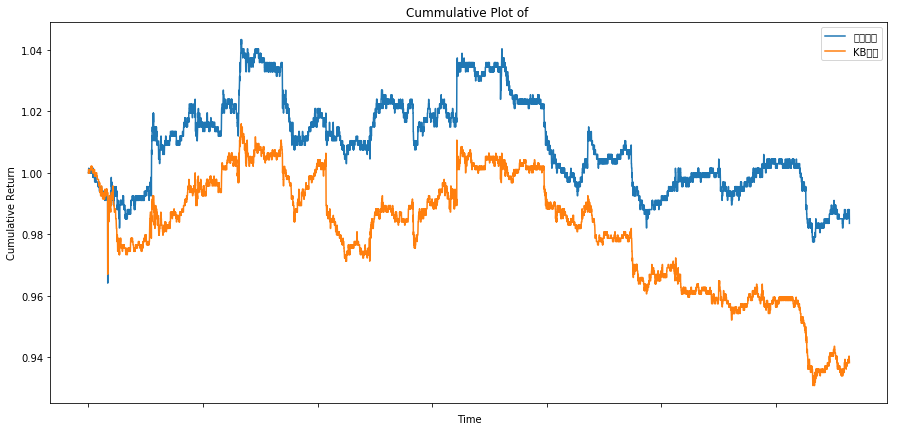

In [13]:
pd.concat([a, b], axis=1).plot(figsize=(15,7))
plt.ylabel('Cumulative Return');
plt.xlabel('Time');
title = 'Cummulative Plot of ' 
plt.title(title)

In [16]:
pvalue = engle_granger_two_step_cointegration_test(a , b )[1]
pvalue

0.00018696852379648622

In [17]:
score, pvalue, _ = coint(a,b)
pvalue

0.11670305245422086